In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
file_path = "../dataset/processed_data.parquet"
df = pd.read_parquet(file_path, engine="pyarrow")

In [3]:
features = [
    "County",
    "City",
    "State",
    "Model Year",
    "Make",
    "Model",
    "Electric Vehicle Type",
    "Clean Alternative Fuel Vehicle (CAFV) Eligibility",
    "Max Range",
]
target = "Fetched Price"

In [4]:
df = df[features + [target]]
df = df[df[target] != 0]

In [5]:
df_feature = df.copy()
model = GradientBoostingRegressor()
for col in df_feature[features].select_dtypes(include=["object"]):
    df_feature[col] = OrdinalEncoder(
        handle_unknown="use_encoded_value", unknown_value=-1
    ).fit_transform(df_feature[[col]])

model.fit(df_feature[features], df_feature[target])

selector = SelectFromModel(model, prefit=True)
selected_features = df_feature[features].columns[(selector.get_support())]

In [6]:
features = selected_features.tolist()

In [7]:
categorical_columns = df[features].select_dtypes(include=["object"]).columns
numeric_columns = df[features].select_dtypes(include=["int64", "float64"]).columns

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        (
            "cat",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
            categorical_columns,
        ),
        ("num", "passthrough", numeric_columns),
    ]
)

In [9]:
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", GradientBoostingRegressor()),
    ]
)

In [10]:
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['Make', 'Model'], dtype='object')),
                                                 ('num', 'passthrough',
                                                  Index(['Max Range'], dtype='object'))])),
                ('regressor', GradientBoostingRegressor())])

In [12]:
y_pred = pipeline.predict(X_test)

In [13]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 17370466.76910611
R^2 Score: 0.933164411886547


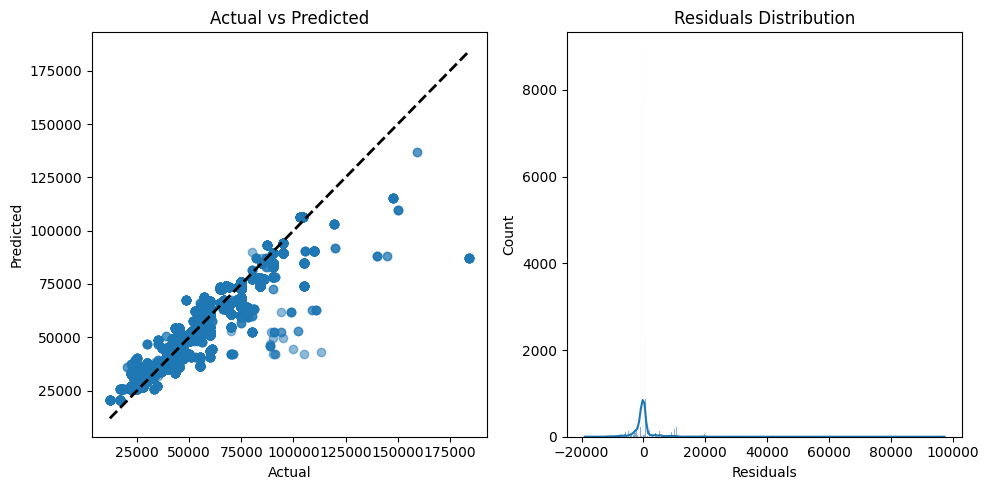

In [14]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")

plt.subplot(1, 2, 2)
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.title("Residuals Distribution")
plt.tight_layout()
plt.show()